<a href="https://colab.research.google.com/github/SANGRAMLEMBE/MTech/blob/main/Deep_Neural_Network/Practical/Feature_extraction_from_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 9 - Tutorial T9: Feature Extraction from Images

In [1]:
# Install required packages
!pip install opencv-python-headless scikit-image scikit-learn matplotlib numpy

print("✅ Installation complete!")

✅ Installation complete!


In [3]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
OpenCV version: 4.12.0
NumPy version: 2.0.2


## Helper Functions for Visualization

These functions will help us display images nicely.(Title, Grid)

In [4]:
def display_image(image, title="Image", cmap=None, figsize=(8, 6)):
    """
    Display a single image with title.

    Args:
        image: Image array
        title: Display title
        cmap: Colormap (None for color images, 'gray' for grayscale)
        figsize: Figure size
    """
    plt.figure(figsize=figsize)
    if len(image.shape) == 3 and image.shape[2] == 3:
        # BGR to RGB for matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap=cmap)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_images_grid(images, titles, rows=1, cols=3, figsize=(15, 5), cmap=None):
    """
    Display multiple images in a grid.

    Args:
        images: List of image arrays
        titles: List of titles
        rows: Number of rows
        cols: Number of columns
        figsize: Figure size
        cmap: Colormap
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for idx, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 3 and img.shape[2] == 3:
            axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            axes[idx].imshow(img, cmap=cmap if cmap else 'gray')
        axes[idx].set_title(title, fontweight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined!")

✅ Helper functions defined!


# Part 1: Shape Features

## 1.1 Create Sample Shapes

create simple geometric shapes to practice on.

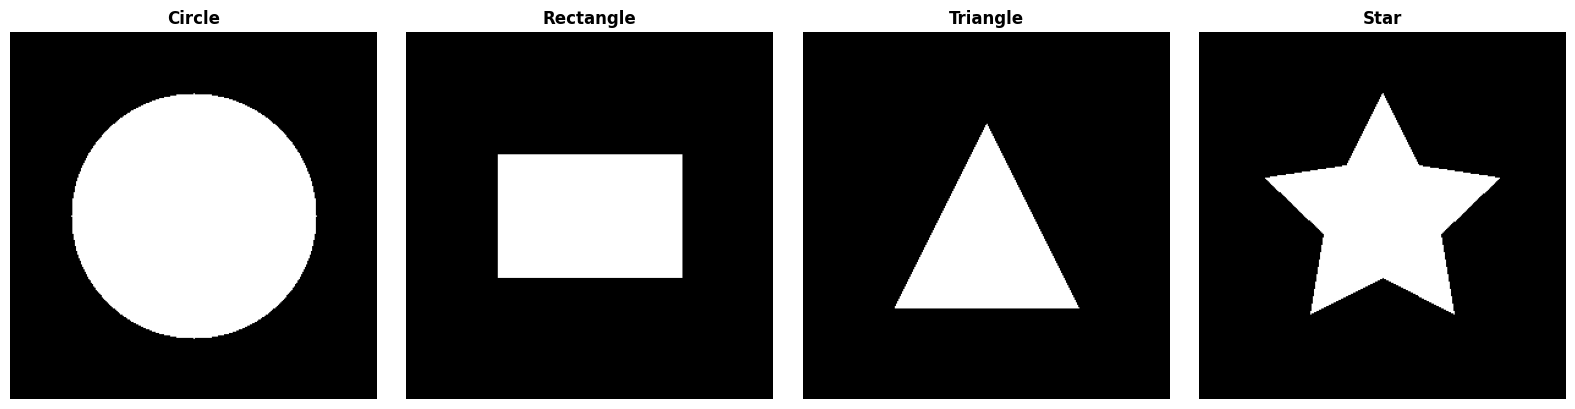

✅ Sample shapes created!


In [5]:
def create_circle(size=300):
    """Create a white circle on black background."""
    img = np.zeros((size, size), dtype=np.uint8)
    center = (size // 2, size // 2)
    radius = size // 3
    cv2.circle(img, center, radius, 255, -1)
    return img

def create_rectangle(size=300):
    """Create a white rectangle on black background."""
    img = np.zeros((size, size), dtype=np.uint8)
    pt1 = (size // 4, size // 3)
    pt2 = (3 * size // 4, 2 * size // 3)
    cv2.rectangle(img, pt1, pt2, 255, -1)
    return img

def create_triangle(size=300):
    """Create a white triangle on black background."""
    img = np.zeros((size, size), dtype=np.uint8)
    pts = np.array([[size//2, size//4], [size//4, 3*size//4], [3*size//4, 3*size//4]])
    cv2.fillPoly(img, [pts], 255)
    return img

def create_star(size=300):
    """Create a white star on black background."""
    img = np.zeros((size, size), dtype=np.uint8)
    center = (size // 2, size // 2)
    outer_radius = size // 3
    inner_radius = size // 6

    # Create 5-pointed star
    pts = []
    for i in range(10):
        angle = i * np.pi / 5 - np.pi / 2
        radius = outer_radius if i % 2 == 0 else inner_radius
        x = int(center[0] + radius * np.cos(angle))
        y = int(center[1] + radius * np.sin(angle))
        pts.append([x, y])

    pts = np.array(pts)
    cv2.fillPoly(img, [pts], 255)
    return img

# Create shapes
circle = create_circle()
rectangle = create_rectangle()
triangle = create_triangle()
star = create_star()

# Display all shapes
display_images_grid(
    [circle, rectangle, triangle, star],
    ['Circle', 'Rectangle', 'Triangle', 'Star'],
    rows=1, cols=4, figsize=(16, 4), cmap='gray'
)

print("✅ Sample shapes created!")

## 1.2 Find Contours

Before extracting features, we need to find the **contours** (boundaries) of objects.

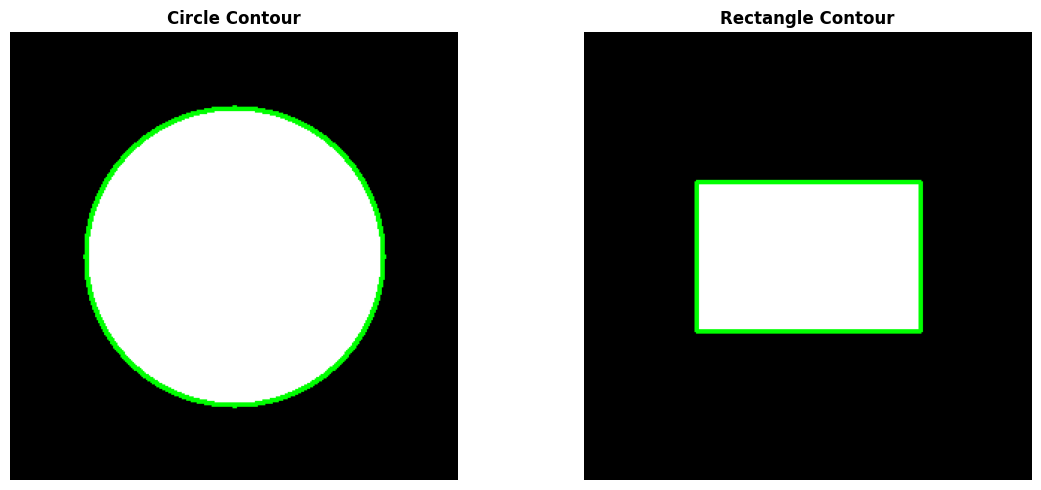

✅ Contours found!
Circle contour points: 292
Rectangle contour points: 4


In [6]:
def find_largest_contour(image):
    """
    Find the largest contour in a binary image.

    Args:
        image: Binary image (0s and 255s)

    Returns:
        Largest contour
    """
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None

    # Find largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Find contours for all shapes
contour_circle = find_largest_contour(circle)
contour_rectangle = find_largest_contour(rectangle)
contour_triangle = find_largest_contour(triangle)
contour_star = find_largest_contour(star)

# Visualize contours
circle_vis = cv2.cvtColor(circle, cv2.COLOR_GRAY2BGR)
cv2.drawContours(circle_vis, [contour_circle], -1, (0, 255, 0), 2)

rectangle_vis = cv2.cvtColor(rectangle, cv2.COLOR_GRAY2BGR)
cv2.drawContours(rectangle_vis, [contour_rectangle], -1, (0, 255, 0), 2)

display_images_grid(
    [circle_vis, rectangle_vis],
    ['Circle Contour', 'Rectangle Contour'],
    rows=1, cols=2, figsize=(12, 5)
)

print("✅ Contours found!")
print(f"Circle contour points: {len(contour_circle)}")
print(f"Rectangle contour points: {len(contour_rectangle)}")

## 1.3 Extract Shape Features

Now let's extract ALL shape features from our contours!

In [7]:
def extract_shape_features(contour):
    """
    Extract comprehensive shape features from a contour.

    Args:
        contour: OpenCV contour object

    Returns:
        Dictionary with shape features
    """
    features = {}

    # 1. Area - How much space inside?
    area = cv2.contourArea(contour)
    features['area'] = area

    # 2. Perimeter - Length of boundary
    perimeter = cv2.arcLength(contour, True)
    features['perimeter'] = perimeter

    # 3. Circularity - How circle-like? (1.0 = perfect circle)
    # Formula: 4π × Area / Perimeter²
    if perimeter > 0:
        circularity = 4 * np.pi * area / (perimeter ** 2)
    else:
        circularity = 0
    features['circularity'] = circularity

    # 4. Bounding Box - Smallest rectangle that fits
    x, y, w, h = cv2.boundingRect(contour)
    features['bbox_x'] = x
    features['bbox_y'] = y
    features['bbox_width'] = w
    features['bbox_height'] = h

    # 5. Aspect Ratio - Tall or wide?
    if h > 0:
        aspect_ratio = float(w) / h
    else:
        aspect_ratio = 0
    features['aspect_ratio'] = aspect_ratio

    # 6. Extent - How well does it fill bounding box?
    rect_area = w * h
    if rect_area > 0:
        extent = area / rect_area
    else:
        extent = 0
    features['extent'] = extent

    # 7. Convex Hull - Smallest convex shape around object
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    features['hull_area'] = hull_area

    # 8. Solidity - How filled is it?
    if hull_area > 0:
        solidity = area / hull_area
    else:
        solidity = 0
    features['solidity'] = solidity

    # 9. Hu Moments - Shape fingerprint (7 values)
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments)

    # Log transform for better scale
    for i in range(7):
        if hu_moments[i][0] != 0:
            hu_moments[i][0] = -np.sign(hu_moments[i][0]) * np.log10(abs(hu_moments[i][0]))

    features['hu_moment_1'] = hu_moments[0][0]
    features['hu_moment_2'] = hu_moments[1][0]
    features['hu_moment_3'] = hu_moments[2][0]
    features['hu_moment_4'] = hu_moments[3][0]
    features['hu_moment_5'] = hu_moments[4][0]
    features['hu_moment_6'] = hu_moments[5][0]
    features['hu_moment_7'] = hu_moments[6][0]

    return features

# Extract features for all shapes
shape_names = ['Circle', 'Rectangle', 'Triangle', 'Star']
contours_list = [contour_circle, contour_rectangle, contour_triangle, contour_star]

print("\n" + "="*80)
print("SHAPE FEATURES EXTRACTION RESULTS")
print("="*80 + "\n")

all_shape_features = []
for name, contour in zip(shape_names, contours_list):
    features = extract_shape_features(contour)
    all_shape_features.append(features)

    print(f"📐 {name.upper()}:")
    print(f"   Area:         {features['area']:.2f} pixels²")
    print(f"   Perimeter:    {features['perimeter']:.2f} pixels")
    print(f"   Circularity:  {features['circularity']:.3f} (1.0 = perfect circle)")
    print(f"   Aspect Ratio: {features['aspect_ratio']:.3f} (1.0 = square)")
    print(f"   Extent:       {features['extent']:.3f} (how well it fills bbox)")
    print(f"   Solidity:     {features['solidity']:.3f} (1.0 = convex shape)")
    print(f"   Hu Moment 1:  {features['hu_moment_1']:.3f} (shape fingerprint)")
    print()

# Create comparison DataFrame
df_shapes = pd.DataFrame(all_shape_features, index=shape_names)
print("\n📊 SHAPE FEATURES COMPARISON TABLE:")
print(df_shapes[['area', 'perimeter', 'circularity', 'aspect_ratio', 'solidity']].round(3))

print("\n✅ Shape features extracted successfully!")


SHAPE FEATURES EXTRACTION RESULTS

📐 CIRCLE:
   Area:         31134.00 pixels²
   Perimeter:    661.75 pixels
   Circularity:  0.893 (1.0 = perfect circle)
   Aspect Ratio: 1.000 (1.0 = square)
   Extent:       0.771 (how well it fills bbox)
   Solidity:     0.994 (1.0 = convex shape)
   Hu Moment 1:  0.798 (shape fingerprint)

📐 RECTANGLE:
   Area:         15000.00 pixels²
   Perimeter:    500.00 pixels
   Circularity:  0.754 (1.0 = perfect circle)
   Aspect Ratio: 1.495 (1.0 = square)
   Extent:       0.984 (how well it fills bbox)
   Solidity:     1.000 (1.0 = convex shape)
   Hu Moment 1:  0.743 (shape fingerprint)

📐 TRIANGLE:
   Area:         11250.00 pixels²
   Perimeter:    512.13 pixels
   Circularity:  0.539 (1.0 = perfect circle)
   Aspect Ratio: 1.000 (1.0 = square)
   Extent:       0.493 (how well it fills bbox)
   Solidity:     0.993 (1.0 = convex shape)
   Hu Moment 1:  0.711 (shape fingerprint)

📐 STAR:
   Area:         14704.00 pixels²
   Perimeter:    697.21 pixels
 

## 1.4 Analyze Shape Features

Let's understand what these numbers tell us!

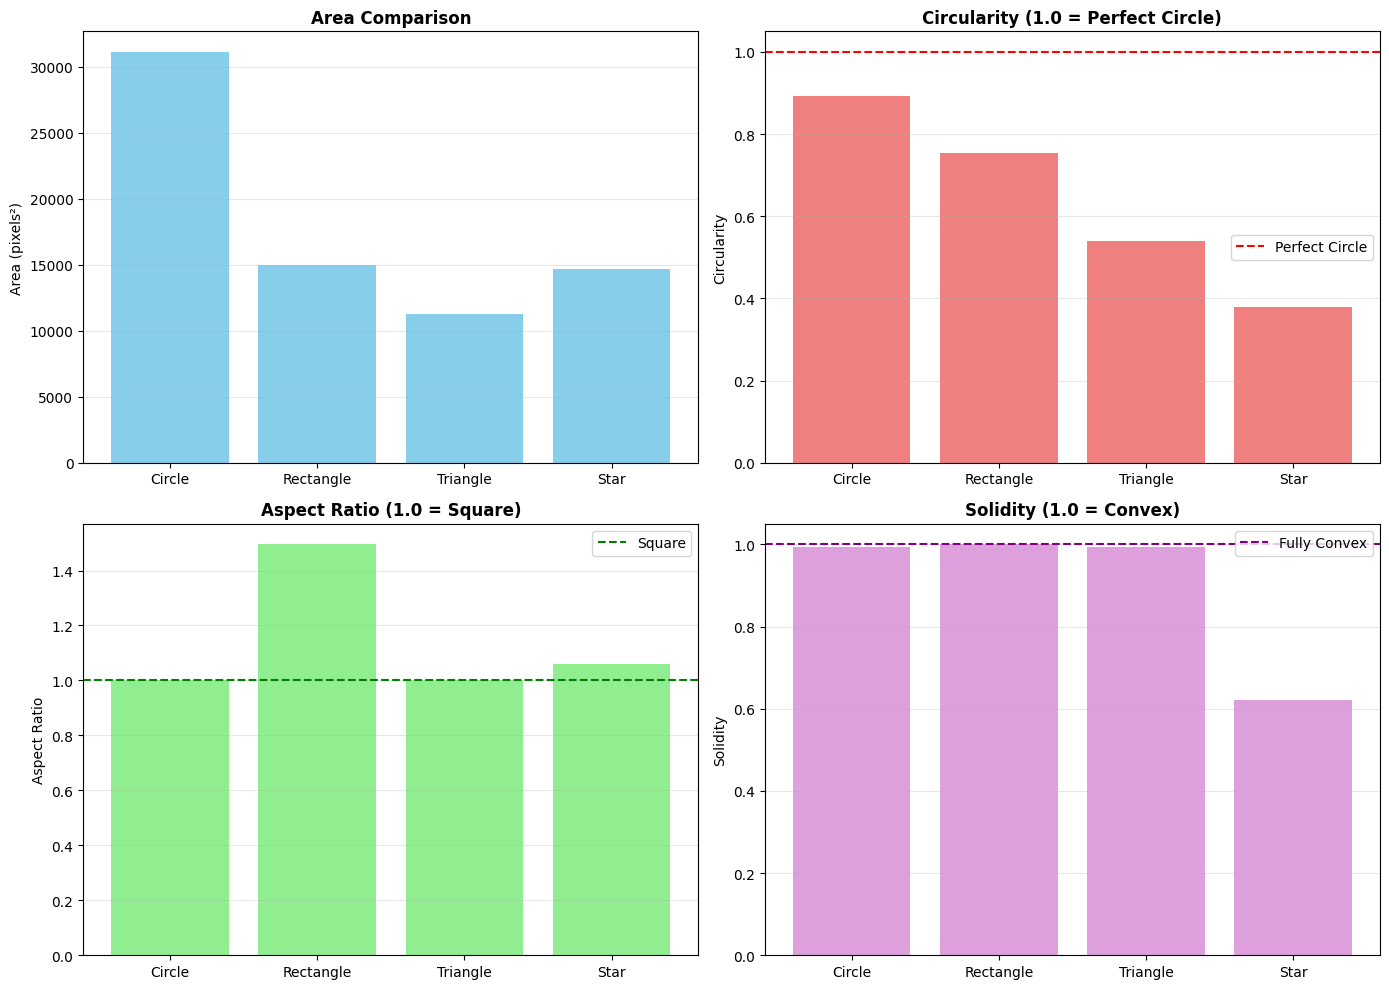


🔍 OBSERVATIONS:
   ✓ Circle has highest circularity (closest to 1.0)
   ✓ Star has lowest solidity (concave shape)
   ✓ Rectangle has aspect ratio ≠ 1.0 (not square)
   ✓ Each shape has unique feature signature!


In [11]:
# Visualize key shape features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Area comparison
axes[0, 0].bar(shape_names, [f['area'] for f in all_shape_features], color='skyblue')
axes[0, 0].set_title('Area Comparison', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Area (pixels²)')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Circularity comparison
axes[0, 1].bar(shape_names, [f['circularity'] for f in all_shape_features], color='lightcoral')
axes[0, 1].set_title('Circularity (1.0 = Perfect Circle)', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Circularity')
axes[0, 1].axhline(y=1.0, color='red', linestyle='--', label='Perfect Circle')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Aspect Ratio comparison
axes[1, 0].bar(shape_names, [f['aspect_ratio'] for f in all_shape_features], color='lightgreen')
axes[1, 0].set_title('Aspect Ratio (1.0 = Square)', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Aspect Ratio')
axes[1, 0].axhline(y=1.0, color='green', linestyle='--', label='Square')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Solidity comparison
axes[1, 1].bar(shape_names, [f['solidity'] for f in all_shape_features], color='plum')
axes[1, 1].set_title('Solidity (1.0 = Convex)', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Solidity')
axes[1, 1].axhline(y=1.0, color='purple', linestyle='--', label='Fully Convex')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 OBSERVATIONS:")
print("   ✓ Circle has highest circularity (closest to 1.0)")
print("   ✓ Star has lowest solidity (concave shape)")
print("   ✓ Rectangle has aspect ratio ≠ 1.0 (not square)")
print("   ✓ Each shape has unique feature signature!")

# Part 2: Color Features 🎨

## 2.1 Create Colored Sample Images

create colorful shapes to practice color feature extraction.

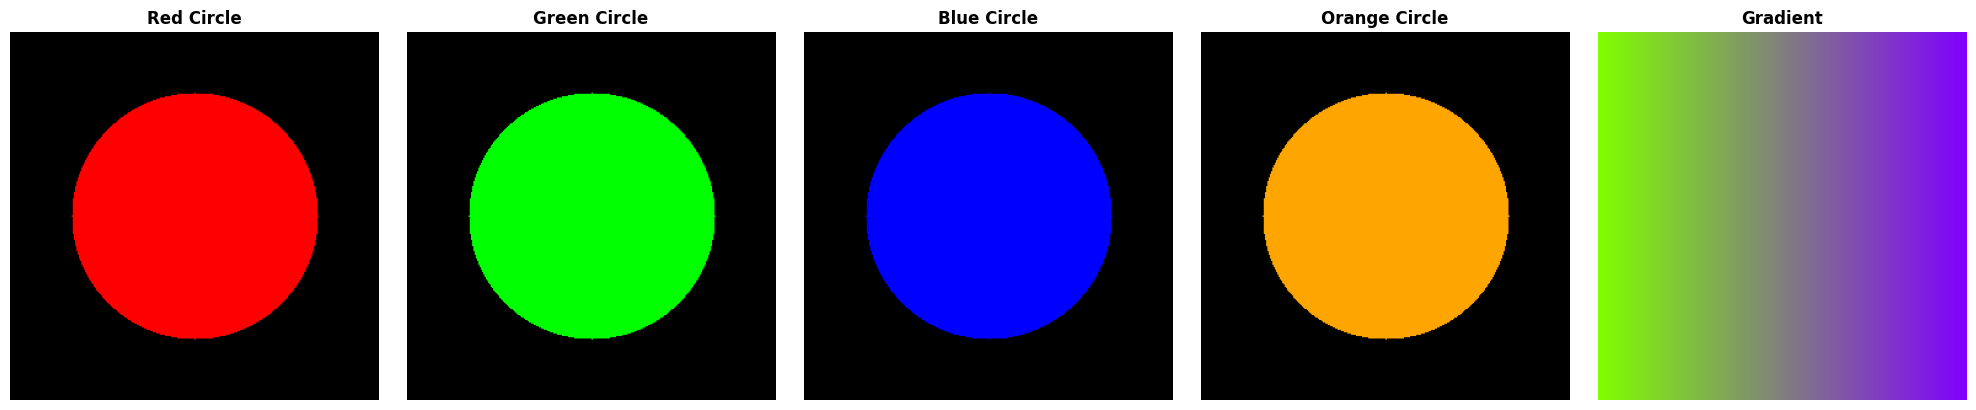

✅ Colored shapes created!


In [12]:
def create_colored_circle(size=300, color=(0, 0, 255)):  # BGR format
    """Create a colored circle."""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    center = (size // 2, size // 2)
    radius = size // 3
    cv2.circle(img, center, radius, color, -1)
    return img

# Create colorful shapes
red_circle = create_colored_circle(color=(0, 0, 255))     # Red in BGR
green_circle = create_colored_circle(color=(0, 255, 0))   # Green
blue_circle = create_colored_circle(color=(255, 0, 0))    # Blue
orange_circle = create_colored_circle(color=(0, 165, 255)) # Orange

# Create a multi-colored gradient image
gradient = np.zeros((300, 300, 3), dtype=np.uint8)
for i in range(300):
    gradient[:, i] = [i * 255 // 300, (300-i) * 255 // 300, 128]

display_images_grid(
    [red_circle, green_circle, blue_circle, orange_circle, gradient],
    ['Red Circle', 'Green Circle', 'Blue Circle', 'Orange Circle', 'Gradient'],
    rows=1, cols=5, figsize=(20, 4)
)

print("✅ Colored shapes created!")

## 2.2 Color Histograms

A histogram shows the **distribution** of pixel intensities for each color channel.

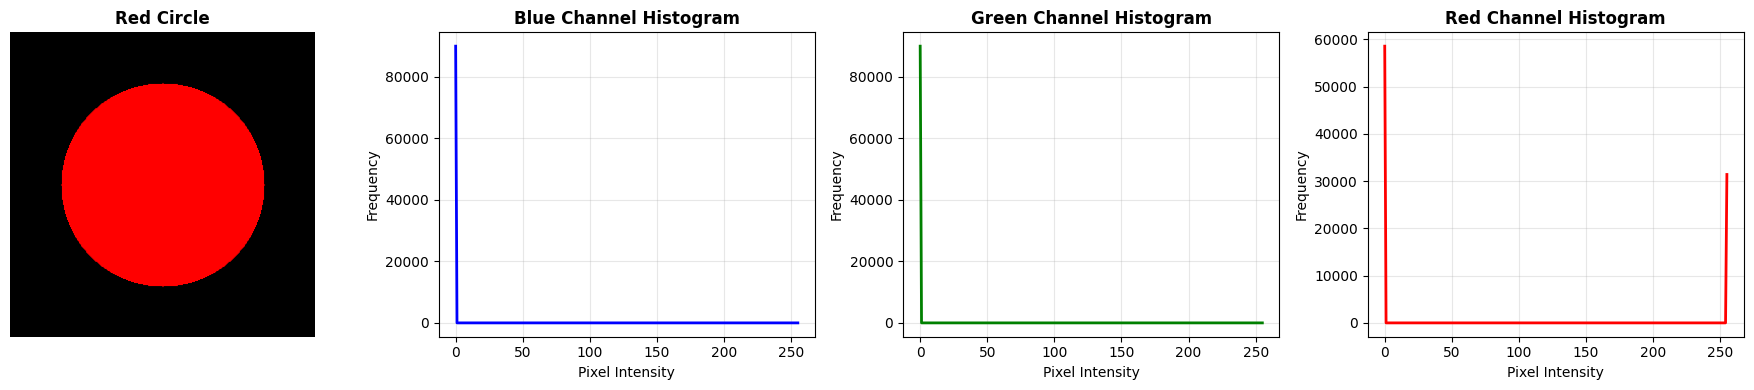


🔍 OBSERVATION:
   ✓ Red channel has high values (peak at 255)
   ✓ Blue and Green channels are near zero
   ✓ This signature uniquely identifies RED objects!


In [13]:
def compute_color_histogram(image, bins=16):
    """
    Compute color histogram for each channel.

    Args:
        image: BGR color image
        bins: Number of bins (default 16 for compact representation)

    Returns:
        Concatenated histogram for all channels
    """
    hist_features = []

    for channel in range(3):
        hist = cv2.calcHist([image], [channel], None, [bins], [0, 256])
        hist = hist.flatten()
        hist = hist / (hist.sum() + 1e-7)  # Normalize
        hist_features.extend(hist)

    return np.array(hist_features)

# Visualize histograms for red circle
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# Display image
axes[0].imshow(cv2.cvtColor(red_circle, cv2.COLOR_BGR2RGB))
axes[0].set_title('Red Circle', fontweight='bold')
axes[0].axis('off')

# Plot histograms for each channel
colors = ['blue', 'green', 'red']  # BGR order
channel_names = ['Blue', 'Green', 'Red']

for i, (color, name) in enumerate(zip(colors, channel_names)):
    hist = cv2.calcHist([red_circle], [i], None, [256], [0, 256])
    axes[i+1].plot(hist, color=color, linewidth=2)
    axes[i+1].set_title(f'{name} Channel Histogram', fontweight='bold')
    axes[i+1].set_xlabel('Pixel Intensity')
    axes[i+1].set_ylabel('Frequency')
    axes[i+1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 OBSERVATION:")
print("   ✓ Red channel has high values (peak at 255)")
print("   ✓ Blue and Green channels are near zero")
print("   ✓ This signature uniquely identifies RED objects!")

## 2.3 Color Statistical Moments

Instead of full histogram (256 values), we can use **statistics** (just 3 numbers per channel)!

In [15]:
def extract_color_features(image):
    """
    Extract comprehensive color features.

    Args:
        image: BGR color image

    Returns:
        Dictionary with color features
    """
    features = {}

    # Convert to different color spaces
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extract mean for each channel (BGR)
    mean_b, mean_g, mean_r = cv2.mean(image)[:3]
    features['mean_blue'] = mean_b
    features['mean_green'] = mean_g
    features['mean_red'] = mean_r

    # Extract standard deviation for each channel
    features['std_blue'] = np.std(image[:, :, 0])
    features['std_green'] = np.std(image[:, :, 1])
    features['std_red'] = np.std(image[:, :, 2])

    # HSV features
    mean_h, mean_s, mean_v = cv2.mean(hsv)[:3]
    features['mean_hue'] = mean_h
    features['mean_saturation'] = mean_s
    features['mean_value'] = mean_v

    # Compact histogram (16 bins per channel)
    hist = compute_color_histogram(image, bins=16)
    for i, val in enumerate(hist):
        features[f'hist_bin_{i}'] = val

    return features

# Extract color features for all colored shapes
colored_shapes = {
    'Red': red_circle,
    'Green': green_circle,
    'Blue': blue_circle,
    'Orange': orange_circle
}

print("\n" + "="*80)
print("COLOR FEATURES EXTRACTION RESULTS")
print("="*80 + "\n")

all_color_features = []
for name, img in colored_shapes.items():
    features = extract_color_features(img)
    all_color_features.append(features)

    print(f"🎨 {name.upper()} CIRCLE:")
    print(f"   Mean BGR:  ({features['mean_blue']:.1f}, {features['mean_green']:.1f}, {features['mean_red']:.1f})")
    print(f"   Std BGR:   ({features['std_blue']:.1f}, {features['std_green']:.1f}, {features['std_red']:.1f})")
    print(f"   Mean HSV:  (H:{features['mean_hue']:.1f}°, S:{features['mean_saturation']:.1f}, V:{features['mean_value']:.1f})")
    print()

# Create comparison DataFrame
df_colors = pd.DataFrame(all_color_features, index=colored_shapes.keys())
print("\n📊 COLOR FEATURES COMPARISON:")
print(df_colors[['mean_blue', 'mean_green', 'mean_red', 'mean_hue', 'mean_saturation']].round(2))

print("\n✅ Color features extracted successfully!")


COLOR FEATURES EXTRACTION RESULTS

🎨 RED CIRCLE:
   Mean BGR:  (0.0, 0.0, 89.0)
   Std BGR:   (0.0, 0.0, 121.6)
   Mean HSV:  (H:0.0°, S:89.0, V:89.0)

🎨 GREEN CIRCLE:
   Mean BGR:  (0.0, 89.0, 0.0)
   Std BGR:   (0.0, 121.6, 0.0)
   Mean HSV:  (H:20.9°, S:89.0, V:89.0)

🎨 BLUE CIRCLE:
   Mean BGR:  (89.0, 0.0, 0.0)
   Std BGR:   (121.6, 0.0, 0.0)
   Mean HSV:  (H:41.9°, S:89.0, V:89.0)

🎨 ORANGE CIRCLE:
   Mean BGR:  (0.0, 57.6, 89.0)
   Std BGR:   (0.0, 78.7, 121.6)
   Mean HSV:  (H:6.6°, S:89.0, V:89.0)


📊 COLOR FEATURES COMPARISON:
        mean_blue  mean_green  mean_red  mean_hue  mean_saturation
Red          0.00        0.00     89.01      0.00            89.01
Green        0.00       89.01      0.00     20.94            89.01
Blue        89.01        0.00      0.00     41.89            89.01
Orange       0.00       57.60     89.01      6.63            89.01

✅ Color features extracted successfully!


## 2.4 Dominant Color Extraction using K-Means

Find the **main colors** in an image using K-means clustering.

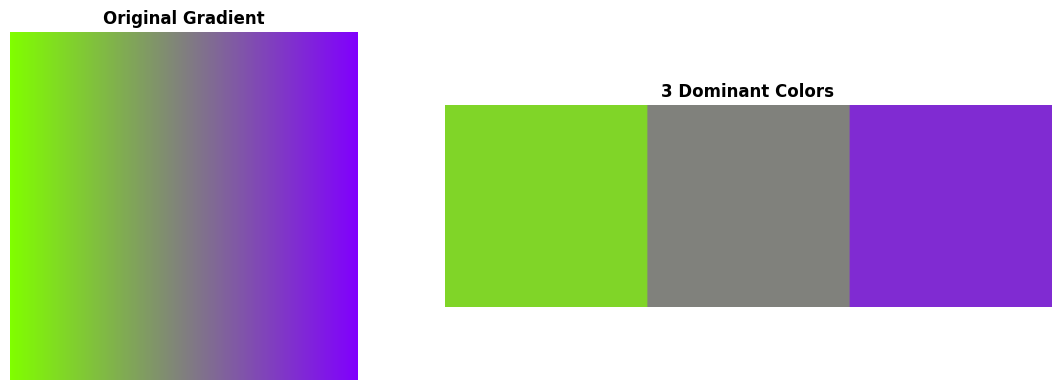


🎨 DOMINANT COLORS (BGR format):
   Color 1: B=40, G=213, R=128
   Color 2: B=124, G=129, R=128
   Color 3: B=210, G=43, R=128

✅ Dominant color extraction complete!


In [16]:
def extract_dominant_colors(image, k=3):
    """
    Extract k dominant colors using K-means clustering.

    Args:
        image: BGR color image
        k: Number of dominant colors to extract

    Returns:
        Array of dominant colors in BGR
    """
    # Reshape image to list of pixels
    pixels = image.reshape(-1, 3).astype(np.float32)

    # K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to uint8
    centers = centers.astype(np.uint8)

    return centers

def visualize_dominant_colors(image, colors):
    """Visualize dominant colors as color palette."""
    palette = np.zeros((100, 300, 3), dtype=np.uint8)
    width = 300 // len(colors)

    for i, color in enumerate(colors):
        palette[:, i*width:(i+1)*width] = color

    return palette

# Extract dominant colors from gradient image
dominant_colors = extract_dominant_colors(gradient, k=3)
palette = visualize_dominant_colors(gradient, dominant_colors)

display_images_grid(
    [gradient, palette],
    ['Original Gradient', '3 Dominant Colors'],
    rows=1, cols=2, figsize=(12, 4)
)

print("\n🎨 DOMINANT COLORS (BGR format):")
for i, color in enumerate(dominant_colors):
    print(f"   Color {i+1}: B={color[0]}, G={color[1]}, R={color[2]}")

print("\n✅ Dominant color extraction complete!")

# Part 3: Texture Features

## 3.1 Create Sample Textures

generate images with different texture patterns.

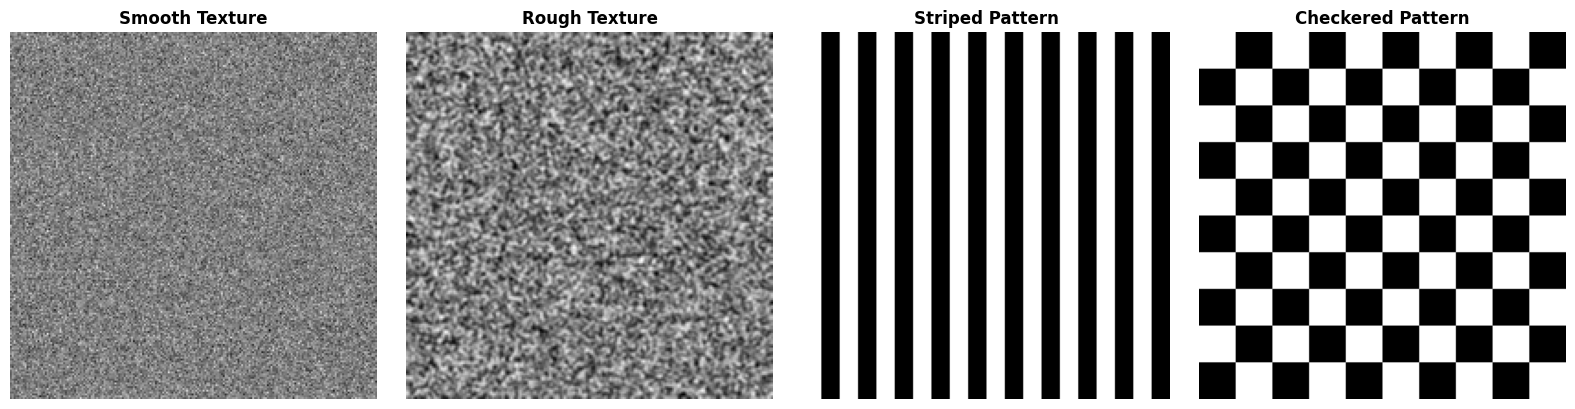

✅ Sample textures created!


In [17]:
def create_smooth_texture(size=200):
    """Create smooth texture (low variation)."""
    texture = np.ones((size, size), dtype=np.uint8) * 128
    # Add slight noise
    noise = np.random.normal(0, 5, (size, size))
    texture = np.clip(texture + noise, 0, 255).astype(np.uint8)
    return texture

def create_rough_texture(size=200):
    """Create rough texture (high variation)."""
    texture = np.random.randint(0, 256, (size, size), dtype=np.uint8)
    # Blur slightly to make it more realistic
    texture = cv2.GaussianBlur(texture, (3, 3), 0)
    return texture

def create_striped_texture(size=200):
    """Create striped texture (regular pattern)."""
    texture = np.zeros((size, size), dtype=np.uint8)
    for i in range(0, size, 20):
        texture[:, i:i+10] = 255
    return texture

def create_checkered_texture(size=200, block_size=20):
    """Create checkered texture."""
    texture = np.zeros((size, size), dtype=np.uint8)
    for i in range(0, size, block_size*2):
        for j in range(0, size, block_size*2):
            texture[i:i+block_size, j:j+block_size] = 255
            texture[i+block_size:i+block_size*2, j+block_size:j+block_size*2] = 255
    return texture

# Create different textures
smooth = create_smooth_texture()
rough = create_rough_texture()
striped = create_striped_texture()
checkered = create_checkered_texture()

display_images_grid(
    [smooth, rough, striped, checkered],
    ['Smooth Texture', 'Rough Texture', 'Striped Pattern', 'Checkered Pattern'],
    rows=1, cols=4, figsize=(16, 4), cmap='gray'
)

print("✅ Sample textures created!")

## 3.2 Simple Texture Features

Let's start with basic texture measurements.

In [18]:
def extract_simple_texture_features(image):
    """
    Extract simple texture features.

    Args:
        image: Grayscale image

    Returns:
        Dictionary with texture features
    """
    features = {}

    # 1. Standard Deviation - Intensity variation
    features['std_dev'] = np.std(image)

    # 2. Edge Density - How many edges?
    edges = cv2.Canny(image, 50, 150)
    edge_density = np.sum(edges > 0) / edges.size
    features['edge_density'] = edge_density

    # 3. Mean intensity
    features['mean_intensity'] = np.mean(image)

    return features

# Extract features for all textures
texture_names = ['Smooth', 'Rough', 'Striped', 'Checkered']
textures = [smooth, rough, striped, checkered]

print("\n" + "="*80)
print("SIMPLE TEXTURE FEATURES")
print("="*80 + "\n")

simple_texture_features = []
for name, texture in zip(texture_names, textures):
    features = extract_simple_texture_features(texture)
    simple_texture_features.append(features)

    print(f"🧵 {name.upper()}:")
    print(f"   Mean Intensity:  {features['mean_intensity']:.2f}")
    print(f"   Std Deviation:   {features['std_dev']:.2f} (higher = more variation)")
    print(f"   Edge Density:    {features['edge_density']:.4f} (higher = rougher)")
    print()

# Visualize
df_texture_simple = pd.DataFrame(simple_texture_features, index=texture_names)
print("\n📊 TEXTURE COMPARISON:")
print(df_texture_simple.round(4))

print("\n✅ Simple texture features extracted!")


SIMPLE TEXTURE FEATURES

🧵 SMOOTH:
   Mean Intensity:  127.49
   Std Deviation:   5.01 (higher = more variation)
   Edge Density:    0.0000 (higher = rougher)

🧵 ROUGH:
   Mean Intensity:  128.04
   Std Deviation:   27.97 (higher = more variation)
   Edge Density:    0.3979 (higher = rougher)

🧵 STRIPED:
   Mean Intensity:  127.50
   Std Deviation:   127.50 (higher = more variation)
   Edge Density:    0.0950 (higher = rougher)

🧵 CHECKERED:
   Mean Intensity:  127.50
   Std Deviation:   127.50 (higher = more variation)
   Edge Density:    0.0819 (higher = rougher)


📊 TEXTURE COMPARISON:
            std_dev  edge_density  mean_intensity
Smooth       5.0060        0.0000        127.4882
Rough       27.9741        0.3979        128.0445
Striped    127.5000        0.0950        127.5000
Checkered  127.5000        0.0819        127.5000

✅ Simple texture features extracted!


## 3.3 GLCM (Gray-Level Co-occurrence Matrix) Features

GLCM analyzes **spatial relationships** between pixel intensities - "How often does pixel value X appear next to pixel value Y?"

In [19]:
def extract_glcm_features(image):
    """
    Extract GLCM texture features.

    Args:
        image: Grayscale image

    Returns:
        Dictionary with GLCM features
    """
    features = {}

    # Normalize image to 0-255 range and reduce to 64 levels for efficiency
    image_normalized = ((image / image.max()) * 255).astype(np.uint8)
    image_reduced = image_normalized // 4  # Reduce to 64 levels

    # Compute GLCM
    # distances: [1] means check immediate neighbors
    # angles: [0, π/4, π/2, 3π/4] means check in 4 directions
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(image_reduced, distances=distances, angles=angles,
                        levels=64, symmetric=True, normed=True)

    # Extract GLCM properties (average over all directions)
    features['glcm_contrast'] = graycoprops(glcm, 'contrast')[0].mean()
    features['glcm_homogeneity'] = graycoprops(glcm, 'homogeneity')[0].mean()
    features['glcm_energy'] = graycoprops(glcm, 'energy')[0].mean()
    features['glcm_correlation'] = graycoprops(glcm, 'correlation')[0].mean()

    return features

print("\n" + "="*80)
print("GLCM TEXTURE FEATURES")
print("="*80 + "\n")

glcm_features_list = []
for name, texture in zip(texture_names, textures):
    features = extract_glcm_features(texture)
    glcm_features_list.append(features)

    print(f"🔬 {name.upper()}:")
    print(f"   Contrast:     {features['glcm_contrast']:.4f} (difference between neighbors)")
    print(f"   Homogeneity:  {features['glcm_homogeneity']:.4f} (uniformity, 1.0 = very uniform)")
    print(f"   Energy:       {features['glcm_energy']:.4f} (pattern repetition)")
    print(f"   Correlation:  {features['glcm_correlation']:.4f} (directional pattern)")
    print()

df_glcm = pd.DataFrame(glcm_features_list, index=texture_names)
print("\n📊 GLCM FEATURES COMPARISON:")
print(df_glcm.round(4))

print("\n🔍 OBSERVATIONS:")
print("   ✓ Smooth texture: High homogeneity, low contrast")
print("   ✓ Rough texture: Low homogeneity, high contrast")
print("   ✓ Regular patterns: High energy (repetitive)")

print("\n✅ GLCM features extracted successfully!")


GLCM TEXTURE FEATURES

🔬 SMOOTH:
   Contrast:     8.9813 (difference between neighbors)
   Homogeneity:  0.3301 (uniformity, 1.0 = very uniform)
   Energy:       0.1378 (pattern repetition)
   Correlation:  0.0024 (directional pattern)

🔬 ROUGH:
   Contrast:     55.4248 (difference between neighbors)
   Homogeneity:  0.1523 (uniformity, 1.0 = very uniform)
   Energy:       0.0394 (pattern repetition)
   Correlation:  0.5591 (directional pattern)

🔬 STRIPED:
   Contrast:     284.2123 (difference between neighbors)
   Homogeneity:  0.9284 (uniformity, 1.0 = very uniform)
   Energy:       0.6591 (pattern repetition)
   Correlation:  0.8568 (directional pattern)

🔬 CHECKERED:
   Contrast:     261.1356 (difference between neighbors)
   Homogeneity:  0.9342 (uniformity, 1.0 = very uniform)
   Energy:       0.6624 (pattern repetition)
   Correlation:  0.8684 (directional pattern)


📊 GLCM FEATURES COMPARISON:
           glcm_contrast  glcm_homogeneity  glcm_energy  glcm_correlation
Smooth   


# Part 4: Complete Feature Extraction Pipeline 🔄

combine **ALL features** (shape + color + texture) into a single feature vector for classification!



## 4.1 Complete Feature Extraction Function

This function extracts ALL features from an image.

In [20]:
def extract_all_features(image, contour=None):
    """
    Extract comprehensive features: shape + color + texture.

    Args:
        image: BGR color image
        contour: Optional contour for shape features

    Returns:
        Feature vector (numpy array)
    """
    feature_vector = []

    # 1. SHAPE FEATURES (if contour provided)
    if contour is not None:
        shape_features = extract_shape_features(contour)
        feature_vector.extend([
            shape_features['area'],
            shape_features['perimeter'],
            shape_features['circularity'],
            shape_features['aspect_ratio'],
            shape_features['extent'],
            shape_features['solidity'],
            shape_features['hu_moment_1'],
            shape_features['hu_moment_2']
        ])

    # 2. COLOR FEATURES
    color_features = extract_color_features(image)
    feature_vector.extend([
        color_features['mean_blue'],
        color_features['mean_green'],
        color_features['mean_red'],
        color_features['std_blue'],
        color_features['std_green'],
        color_features['std_red'],
        color_features['mean_hue'],
        color_features['mean_saturation'],
        color_features['mean_value']
    ])

    # 3. TEXTURE FEATURES
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    simple_texture = extract_simple_texture_features(gray)
    glcm_texture = extract_glcm_features(gray)

    feature_vector.extend([
        simple_texture['std_dev'],
        simple_texture['edge_density'],
        glcm_texture['glcm_contrast'],
        glcm_texture['glcm_homogeneity'],
        glcm_texture['glcm_energy'],
        glcm_texture['glcm_correlation']
    ])

    return np.array(feature_vector)

# Test with red circle
test_contour = find_largest_contour(cv2.cvtColor(red_circle, cv2.COLOR_BGR2GRAY))
test_features = extract_all_features(red_circle, test_contour)

print("\n" + "="*80)
print("COMPLETE FEATURE VECTOR EXAMPLE")
print("="*80 + "\n")
print(f"Feature vector length: {len(test_features)} features")
print(f"\nFeature breakdown:")
print(f"   Shape features:    8 values")
print(f"   Color features:    9 values")
print(f"   Texture features:  6 values")
print(f"   Total:            {len(test_features)} values")
print(f"\nFirst 10 features: {test_features[:10]}")

print("\n✅ Complete feature extraction function ready!")


COMPLETE FEATURE VECTOR EXAMPLE

Feature vector length: 23 features

Feature breakdown:
   Shape features:    8 values
   Color features:    9 values
   Texture features:  6 values
   Total:            23 values

First 10 features: [3.11340000e+04 6.61754398e+02 8.93410623e-01 1.00000000e+00
 7.70624489e-01 9.93744015e-01 7.98170213e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00]

✅ Complete feature extraction function ready!


---

# Part 5: Classification Pipeline 🎯

Now we'll use our extracted features to **classify objects** using traditional machine learning!

---

## 5.1 Create a Simple Dataset

Let's create a small dataset of different colored shapes.

In [21]:
def create_dataset(num_samples_per_class=20):
    """
    Create a synthetic dataset of colored shapes.

    Returns:
        X: Feature matrix (samples × features)
        y: Labels
    """
    X = []
    y = []

    classes = [
        ('red_circle', (0, 0, 255)),
        ('green_circle', (0, 255, 0)),
        ('blue_square', (255, 0, 0))
    ]

    for class_name, base_color in classes:
        for _ in range(num_samples_per_class):
            # Add some variation to color
            color = tuple([int(c + np.random.randint(-30, 30)) for c in base_color])
            color = tuple([max(0, min(255, c)) for c in color])  # Clip to valid range

            # Create shape
            if 'circle' in class_name:
                img = create_colored_circle(color=color)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                contour = find_largest_contour(gray)
            else:  # square
                img = np.zeros((300, 300, 3), dtype=np.uint8)
                pt1 = (75, 75)
                pt2 = (225, 225)
                cv2.rectangle(img, pt1, pt2, color, -1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                contour = find_largest_contour(gray)

            # Extract features
            features = extract_all_features(img, contour)
            X.append(features)
            y.append(class_name)

    return np.array(X), np.array(y)

# Create dataset
print("\n⏳ Creating dataset...")
X, y = create_dataset(num_samples_per_class=30)

print(f"\n✅ Dataset created!")
print(f"   Total samples: {len(X)}")
print(f"   Features per sample: {X.shape[1]}")
print(f"   Classes: {np.unique(y)}")
print(f"   Samples per class: {len(y[y == 'red_circle'])}")


⏳ Creating dataset...

✅ Dataset created!
   Total samples: 90
   Features per sample: 23
   Classes: ['blue_square' 'green_circle' 'red_circle']
   Samples per class: 30


## 5.2 Train Multiple Classifiers

Let's train three different classifiers and compare their performance!

In [22]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features normalized!")

# Train multiple classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Support Vector Machine': SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

print("\n" + "="*80)
print("TRAINING CLASSIFIERS")
print("="*80 + "\n")

results = {}
for name, clf in classifiers.items():
    print(f"🤖 Training {name}...")
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"   Accuracy: {accuracy*100:.2f}%")
    print()

print("\n✅ All classifiers trained!")

Training set: 63 samples
Test set: 27 samples

✅ Features normalized!

TRAINING CLASSIFIERS

🤖 Training K-Nearest Neighbors...
   Accuracy: 100.00%

🤖 Training Support Vector Machine...
   Accuracy: 100.00%

🤖 Training Random Forest...
   Accuracy: 100.00%


✅ All classifiers trained!


## 5.3 Evaluate and Compare Classifiers


BEST CLASSIFIER: K-Nearest Neighbors

📊 CLASSIFICATION REPORT:

              precision    recall  f1-score   support

 blue_square       1.00      1.00      1.00         9
green_circle       1.00      1.00      1.00         9
  red_circle       1.00      1.00      1.00         9

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



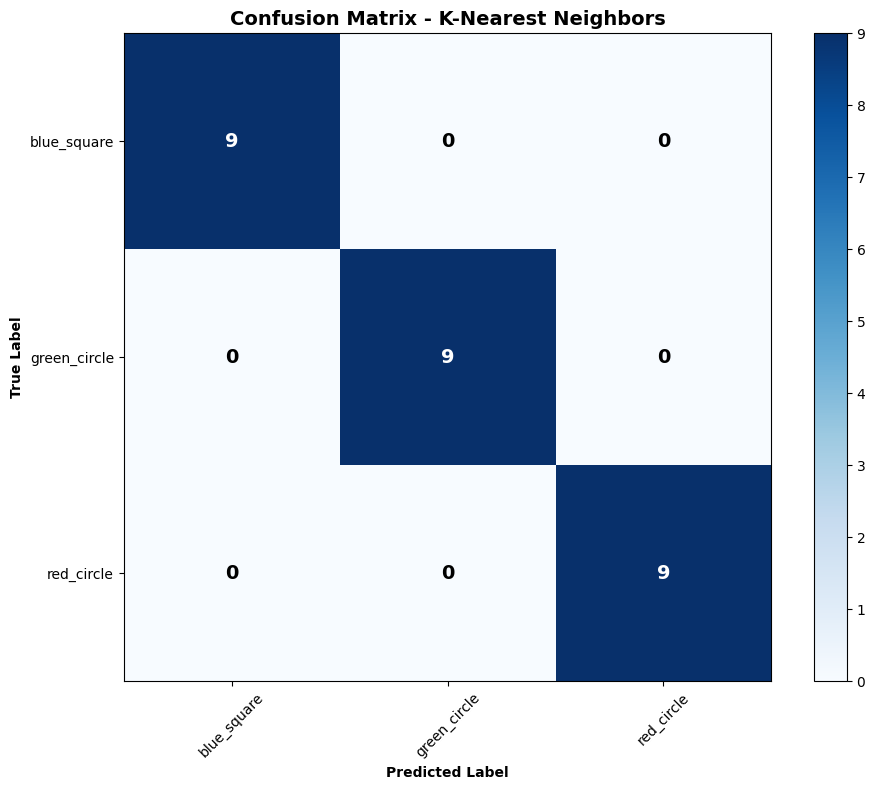

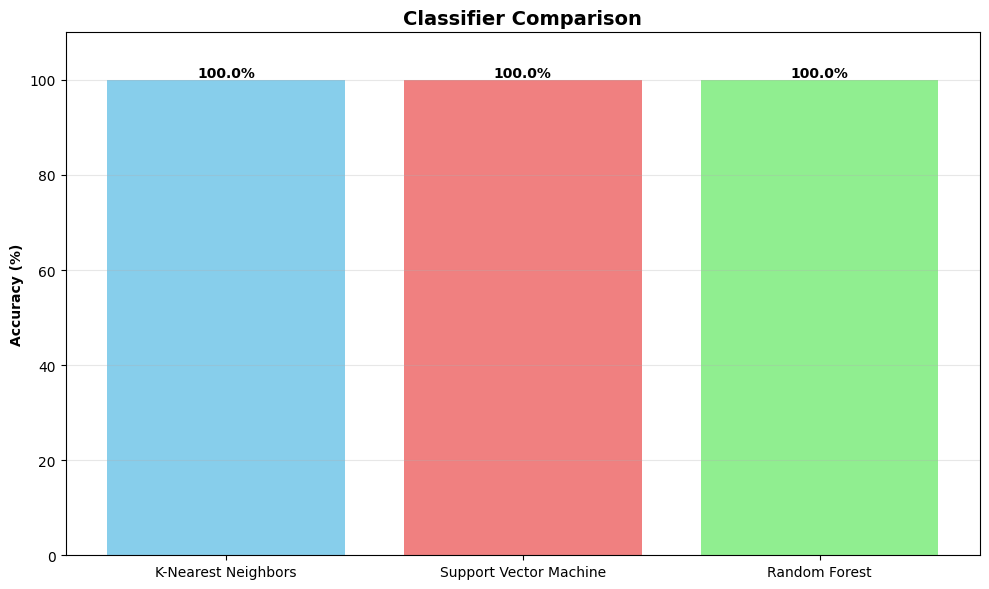


✅ Evaluation complete!


In [23]:
# Choose best classifier
best_classifier_name = max(results, key=results.get)
best_classifier = classifiers[best_classifier_name]
y_pred = best_classifier.predict(X_test_scaled)

print("\n" + "="*80)
print(f"BEST CLASSIFIER: {best_classifier_name}")
print("="*80 + "\n")

# Classification report
print("📊 CLASSIFICATION REPORT:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(y)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title(f'Confusion Matrix - {best_classifier_name}', fontweight='bold', fontsize=14)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add numbers to cells
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=14, fontweight='bold')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Compare all classifiers
plt.figure(figsize=(10, 6))
names = list(results.keys())
accuracies = [results[name] * 100 for name in names]
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = plt.bar(names, accuracies, color=colors)
plt.title('Classifier Comparison', fontweight='bold', fontsize=14)
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.ylim([0, 110])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete!")

## 5.4 Test with New Images

Let's create a new shape and see how our classifier performs!


TESTING WITH NEW IMAGES

🔍 Test Red Circle:
   Predicted Class: red_circle
   Confidence: 100.0%
   All Probabilities:
      blue_square: 0.0%
      green_circle: 0.0%
      red_circle: 100.0%

🔍 Test Green Circle:
   Predicted Class: green_circle
   Confidence: 100.0%
   All Probabilities:
      blue_square: 0.0%
      green_circle: 100.0%
      red_circle: 0.0%

🔍 Test Blue Square:
   Predicted Class: blue_square
   Confidence: 100.0%
   All Probabilities:
      blue_square: 100.0%
      green_circle: 0.0%
      red_circle: 0.0%



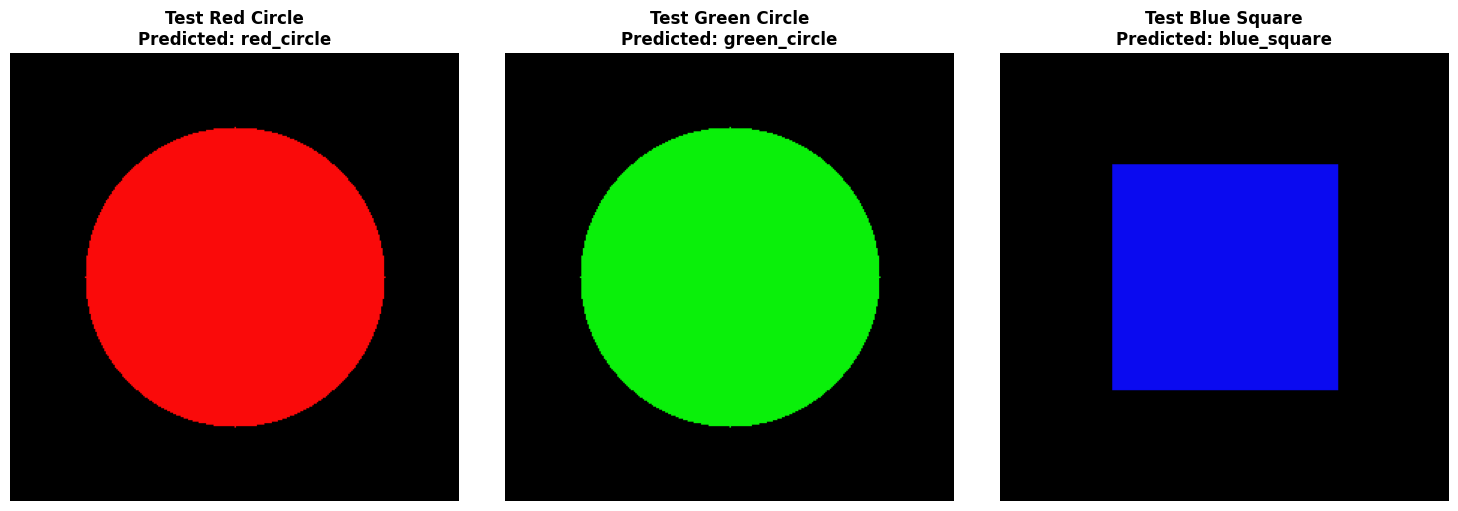

✅ Prediction complete!


In [24]:
def predict_shape(image, contour, classifier, scaler):
    """
    Predict the class of a shape.

    Args:
        image: BGR color image
        contour: Shape contour
        classifier: Trained classifier
        scaler: Fitted scaler

    Returns:
        Predicted class and probabilities
    """
    # Extract features
    features = extract_all_features(image, contour)
    features_scaled = scaler.transform([features])

    # Predict
    prediction = classifier.predict(features_scaled)[0]
    probabilities = classifier.predict_proba(features_scaled)[0]

    return prediction, probabilities

# Create test images
test_red = create_colored_circle(color=(10, 10, 250))  # Red circle
test_green = create_colored_circle(color=(10, 240, 10))  # Green circle
test_blue_rect = np.zeros((300, 300, 3), dtype=np.uint8)
cv2.rectangle(test_blue_rect, (75, 75), (225, 225), (240, 10, 10), -1)  # Blue square

test_images = [test_red, test_green, test_blue_rect]
test_names = ['Test Red Circle', 'Test Green Circle', 'Test Blue Square']

print("\n" + "="*80)
print("TESTING WITH NEW IMAGES")
print("="*80 + "\n")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (img, name) in enumerate(zip(test_images, test_names)):
    # Find contour
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contour = find_largest_contour(gray)

    # Predict
    prediction, probs = predict_shape(img, contour, best_classifier, scaler)

    # Display
    axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f'{name}\nPredicted: {prediction}', fontweight='bold')
    axes[idx].axis('off')

    # Print results
    print(f"🔍 {name}:")
    print(f"   Predicted Class: {prediction}")
    print(f"   Confidence: {max(probs)*100:.1f}%")
    print(f"   All Probabilities:")
    for cls, prob in zip(best_classifier.classes_, probs):
        print(f"      {cls}: {prob*100:.1f}%")
    print()

plt.tight_layout()
plt.show()

print("✅ Prediction complete!")